In [ ]:
! pip install transformers -q


In [ ]:
pip install wget

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9676 sha256=436fa381d1824d86250a9ef9cc9bb67b35410ea832fe969f64d61d3b0640bea8
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget


In [ ]:
from PIL import Image

from transformers import pipeline

"""# Image Captioning"""

#load image caption pipeline
caption = pipeline('image-to-text')
  
# open method used to open different extension image file



No model was supplied, defaulted to ydshieh/vit-gpt2-coco-en and revision 65636df (https://huggingface.co/ydshieh/vit-gpt2-coco-en).
Using a pipeline without specifying a model name and revision in production is not recommended.
Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [ ]:
import pandas as pd
import csv
import os
from transformers import pipeline

# Load the dataset
df = pd.read_csv('/content/Untitled Folder/AAAI_dataset/politi_test.csv')


# Define the folder path containing the images
folder_path = "/content/Untitled Folder/AAAI_dataset/Images/politi_test/"

# Install transformers library
! pip install transformers -q

# Load image captioning pipeline
caption = pipeline('image-to-text')

# Loop through all rows in the dataframe
captions = []
for index, row in df.iterrows():
    # Get the image file name and clean caption for the current row
    image_file = row['image']
    clean_caption = row['content']
    towway_label = row['label']
    
    # Combine the folder path and the image file name
    image_path = os.path.join(folder_path, image_file)

    if pd.isna(image_path) or not os.path.exists(image_path):
        print(f"Invalid image path: {image_path}")
        continue
    
    # Generate the image caption
    caption_text = caption(image_path)[0]['generated_text']
    print(caption_text)
    
    # Store the image path, clean caption, and generated caption in a list
    captions.append({
        'image_path': image_path,
        'clean_caption': clean_caption,
        'generated_caption': caption_text,
        '2_way_label': towway_label
    })

# Convert the list of captions to a dataframe
captions_df = pd.DataFrame(captions)

# Save the dataframe to a CSV file
captions_df.to_csv('politi_testcaptions.csv', index=False)

In [ ]:
import pandas as pd
import csv
import requests
import pandas as pd
import wget

# Load the dataset
df = pd.read_csv('/content/drive/MyDrive/train_clean.csv')
df=df[:5000]

# Install transformers library
! pip install transformers -q

# Load image captioning pipeline
caption = pipeline('image-to-text')

# Loop through all rows in the dataframe
captions = []
for index, row in df.iterrows():
    # Get the image URL and clean caption for the current row
    image_url = row['image_url']
    clean_caption = row['clean_title']
    towway_label= row['2_way_label']
    
    if pd.isna(image_url):
        print(f"Invalid image URL: {image_url}")
        continue
    
    # Make a HEAD request to the URL to check if it exists
    try:
        response = requests.head(image_url)
        if response.status_code != 200:
            print(f"Invalid image URL: {image_url}")
            continue
    except:
        print(f"Error making request to URL: {image_url}")
        continue
    # Download the image file
    response = requests.head(image_url)
    filename = wget.download(image_url)
    
    # Generate the image caption
    caption_text = caption(filename)[0]['generated_text']
    print(caption_text)
    
    # Store the image URL, clean caption, and generated caption in a list
    captions.append({
        'image_url': image_url,
        'clean_caption': clean_caption,
        'generated_caption': caption_text,
        '2_way_label': towway_label
    })

# Convert the list of captions to a dataframe
captions_df = pd.DataFrame(captions)

# Save the dataframe to a CSV file
captions_df.to_csv('captions.csv', index=False)

In [ ]:
captions_df.to_csv('captions.csv', index=False)

In [ ]:
cd /content/drive/MyDrive

/content/drive/MyDrive


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
pip install tensorflow tensorflow-text

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 27.9 MB/s eta 0:00:00


**CNN**

In [21]:
!pip install scikit-plot
!pip install matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [22]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping
from sklearn.metrics.pairwise import cosine_similarity
import scikitplot as skplt
import matplotlib.pyplot as plt

# Read train and test CSV files
train_data = pd.read_csv('/content/drive/MyDrive/politycaptiontrain.csv')
test_data = pd.read_csv('/content/drive/MyDrive/politi_testcaptions.csv')

# Load the Universal Sentence Encoder
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

# Function to prepare input and output arrays
def prepare_data(data):
    sent1_vecs = embed(data['clean_caption']).numpy()
    sent2_vecs = embed(data['generated_caption']).numpy()

    sim_scores = [cosine_similarity(sent1.reshape(1,-1), sent2.reshape(1,-1))[0][0] for sent1, sent2 in zip(sent1_vecs, sent2_vecs)]

    X = []
    y = data['2_way_label'].values

    for i, row in data.iterrows():
        sent1 = sent1_vecs[i]
        sent2 = sent2_vecs[i]
        similarity = sim_scores[i]
        X.append(np.concatenate((sent1, sent2, np.array([similarity], ndmin=1))))

    return np.array(X), y

# Prepare train and test data
X_train, y_train = prepare_data(train_data)
X_test, y_test = prepare_data(test_data)

# Define and train classification model
model = Sequential()
model.add(Dense(256, input_dim=X_train.shape[1], activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Use early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])



Epoch 1/100
12/12 [==============================] - 9s 62ms/step - loss: 1.0473 - accuracy: 0.5039 - val_loss: 0.6642 - val_accuracy: 0.7212
Epoch 2/100
12/12 [==============================] - 0s 27ms/step - loss: 0.8068 - accuracy: 0.6115 - val_loss: 0.6513 - val_accuracy: 0.7212
Epoch 3/100
12/12 [==============================] - 0s 21ms/step - loss: 0.6384 - accuracy: 0.6903 - val_loss: 0.6408 - val_accuracy: 0.7212
Epoch 4/100
12/12 [==============================] - 0s 21ms/step - loss: 0.5994 - accuracy: 0.6903 - val_loss: 0.6234 - val_accuracy: 0.7308
Epoch 5/100
12/12 [==============================] - 0s 19ms/step - loss: 0.5394 - accuracy: 0.7664 - val_loss: 0.6048 - val_accuracy: 0.7596
Epoch 6/100
12/12 [==============================] - 0s 23ms/step - loss: 0.4972 - accuracy: 0.7743 - val_loss: 0.5835 - val_accuracy: 0.7788
Epoch 7/100
12/12 [==============================] - 0s 25ms/step - loss: 0.4458 - accuracy: 0.7874 - val_loss: 0.5613 - val_accuracy: 0.7788
Epoch 

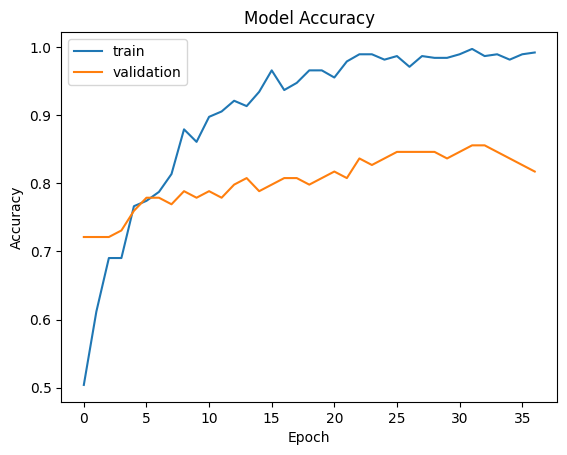

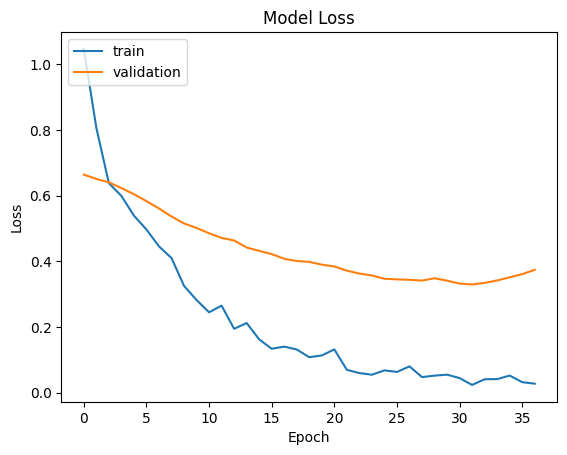

4/4 [==============================] - 0s 4ms/step


In [23]:
from sklearn.metrics import roc_curve, auc, confusion_matrix

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Plot train and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Generate ROC curve and AUC
y_pred_proba = model.predict(X_test)
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)


In [24]:
y_pred_proba = model.predict(X_test)
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

4/4 [==============================] - 0s 4ms/step


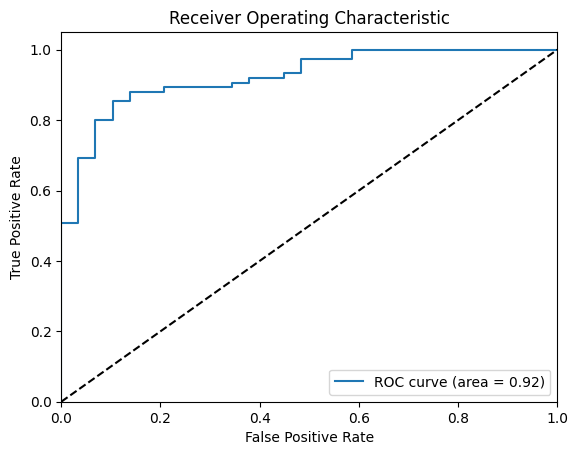

In [25]:
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [26]:
loss, accuracy = model.evaluate(X_test, y_test)

print("Loss:", loss)
print("Accuracy:", accuracy)


4/4 [==============================] - 0s 9ms/step - loss: 0.3297 - accuracy: 0.8558
Loss: 0.32970669865608215
Accuracy: 0.8557692170143127


In [27]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

# Get the model's predictions on the test set
y_pred = model.predict(X_test)

# Convert the predictions to binary labels (0 or 1)
y_pred_labels = (y_pred > 0.5).astype(int).flatten()

# Calculate precision, recall, and F1-score
precision = precision_score(y_test, y_pred_labels)
recall = recall_score(y_test, y_pred_labels)
f1 = f1_score(y_test, y_pred_labels)

# Print the metrics
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

# Calculate and print the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_labels)
print("Confusion Matrix:\n", conf_matrix)

4/4 [==============================] - 0s 8ms/step
Precision: 0.9054054054054054
Recall: 0.8933333333333333
F1-score: 0.8993288590604026
Confusion Matrix:
 [[22  7]
 [ 8 67]]


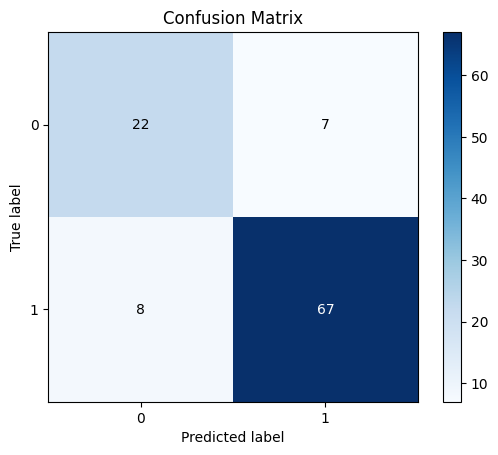

In [28]:
#y_pred = model.predict(X_test)

# Generate confusion matrix
#cm = confusion_matrix(y_test, y_pred_labels)

# Plot colorful confusion matrix
skplt.metrics.plot_confusion_matrix(y_test, y_pred_labels, normalize=False, cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

### GRID SEARCH****

MLP

In [29]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
from keras.models import Sequential
from keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split, GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

# Function to create an MLP model with a variable number of hidden layers and neurons
def create_mlp_model(hidden_layers=1, neurons_per_layer=256):
    model = Sequential()
    model.add(Dense(neurons_per_layer, activation='relu', input_shape=(X_train.shape[1],)))
    model.add(Dropout(0.5))

    for _ in range(hidden_layers - 1):
        model.add(Dense(neurons_per_layer, activation='relu'))
        model.add(Dropout(0.5))

    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Read train and test CSV files
train_data = pd.read_csv('/content/drive/MyDrive/politycaptiontrain.csv')
test_data = pd.read_csv('/content/drive/MyDrive/politi_testcaptions.csv')

# Load the Universal Sentence Encoder
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

# Function to prepare input and output arrays
def prepare_data(data):
    sent1_vecs = embed(data['clean_caption']).numpy()
    sent2_vecs = embed(data['generated_caption']).numpy()

    sim_scores = [cosine_similarity(sent1.reshape(1,-1), sent2.reshape(1,-1))[0][0] for sent1, sent2 in zip(sent1_vecs, sent2_vecs)]

    X = []
    y = data['2_way_label'].values

    for i, row in data.iterrows():
        sent1 = sent1_vecs[i]
        sent2 = sent2_vecs[i]
        similarity = sim_scores[i]
        X.append(np.concatenate((sent1, sent2, np.array([similarity], ndmin=1))))

    return np.array(X), y

# Prepare train and test data
X_train, y_train = prepare_data(train_data)
X_test, y_test = prepare_data(test_data)

# Grid search parameters
param_grid = {
    'hidden_layers': [1, 2, 3],
    'neurons_per_layer': [128, 256, 512]
}

# Create KerasClassifier with the create_mlp_model function
model = KerasClassifier(build_fn=create_mlp_model, epochs=100, batch_size=32, verbose=0)

# Perform grid search
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3)
grid_result = grid.fit(X_train, y_train)

# Print the best parameters
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

# Evaluate the best model on the test set
best_model = grid_result.best_estimator_.model
best_model.evaluate(X_test, y_test)




<ipython-input-29-78ee736c170a>:60: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_mlp_model, epochs=100, batch_size=32, verbose=0)


Best: 0.860892 using {'hidden_layers': 1, 'neurons_per_layer': 512}
4/4 [==============================] - 0s 7ms/step - loss: 0.5844 - accuracy: 0.8558


[0.5844417214393616, 0.8557692170143127]

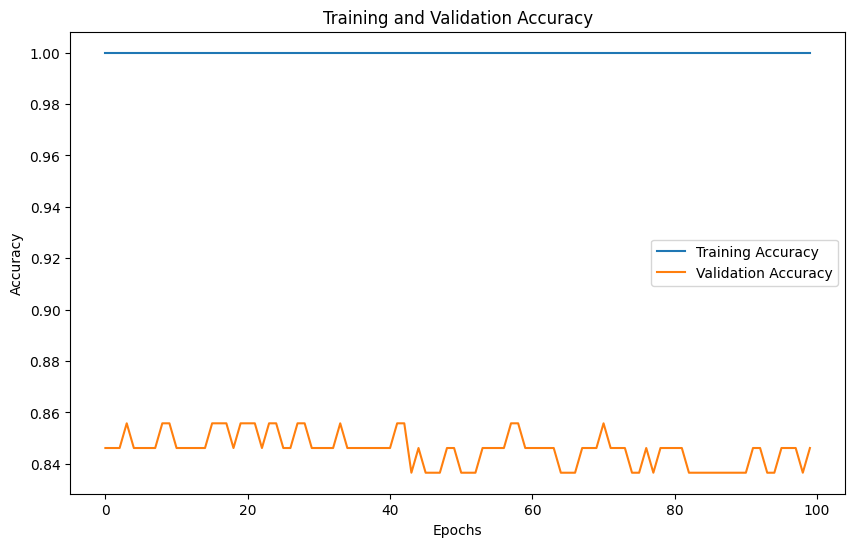

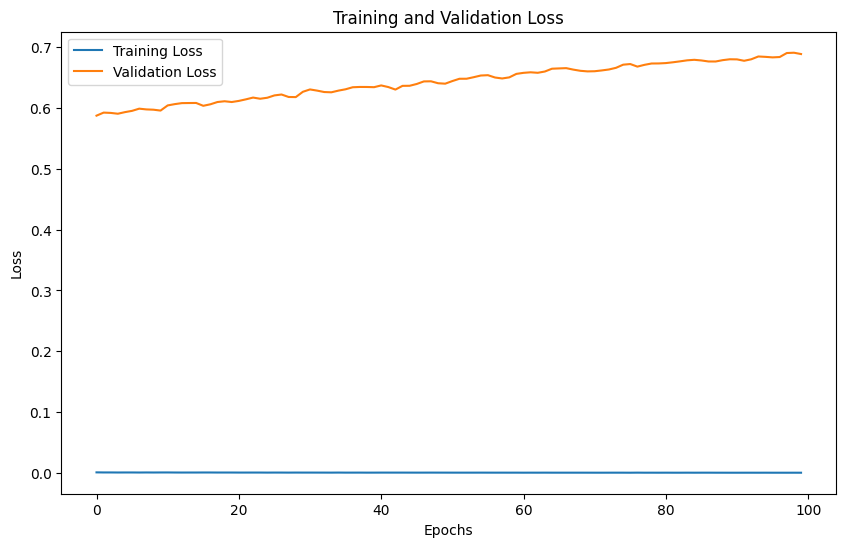

4/4 [==============================] - 0s 4ms/step


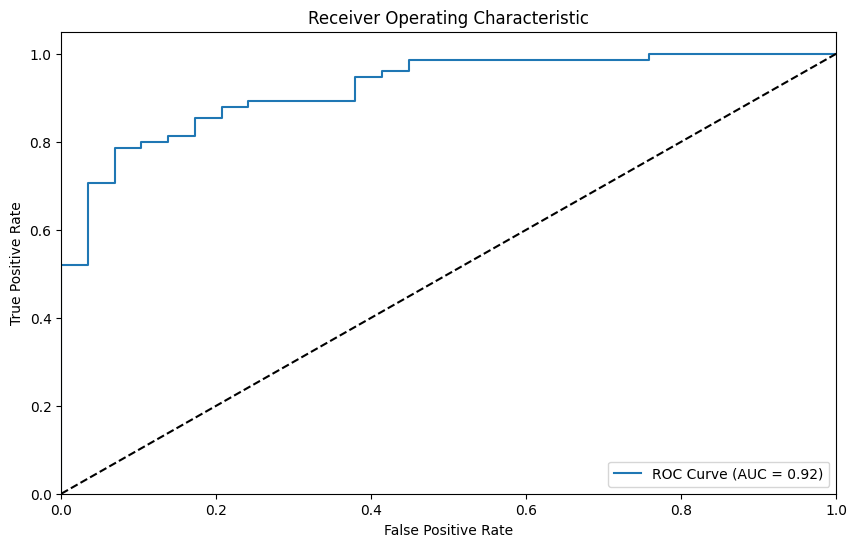

In [30]:
from sklearn.metrics import roc_curve, auc, confusion_matrix
history = best_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=32, verbose=0)

# Plot training accuracy and validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

# Plot training loss and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Generate predictions
y_pred_prob = best_model.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label='ROC Curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

# Confusion matrix


4/4 [==============================] - 0s 6ms/step


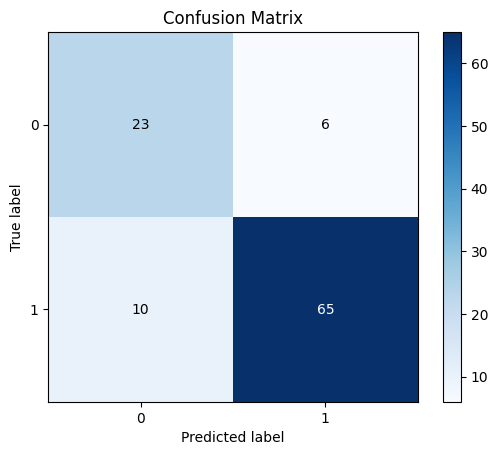

In [31]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

# Get the model's predictions on the test set
y_pred = best_model.predict(X_test)

# Convert the predictions to binary labels (0 or 1)
y_pred_labels = (y_pred > 0.5).astype(int).flatten()
skplt.metrics.plot_confusion_matrix(y_test, y_pred_labels, normalize=False, cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

In [32]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

# Get the model's predictions on the test set
y_pred = best_model.predict(X_test)

# Convert the predictions to binary labels (0 or 1)
y_pred_labels = (y_pred > 0.5).astype(int).flatten()

# Calculate precision, recall, and F1-score
precision = precision_score(y_test, y_pred_labels)
recall = recall_score(y_test, y_pred_labels)
f1 = f1_score(y_test, y_pred_labels)

# Print the metrics
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

# Calculate and print the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_labels)
print("Confusion Matrix:\n", conf_matrix)

4/4 [==============================] - 0s 4ms/step
Precision: 0.9154929577464789
Recall: 0.8666666666666667
F1-score: 0.8904109589041095
Confusion Matrix:
 [[23  6]
 [10 65]]


In [33]:
!unzip "/content/drive/MyDrive/AAAI_dataset.zip" -d "/content/Untitled Folder"

Archive:  /content/drive/MyDrive/AAAI_dataset.zip
replace /content/Untitled Folder/AAAI_dataset/Images/gossip_test/02s3CNoDOz8F0oeX3tA74g6CRpmxHnvc.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

LSTM

In [34]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Bidirectional
from sklearn.model_selection import train_test_split

# Read train and test CSV files
train_data = pd.read_csv('/content/drive/MyDrive/politycaptiontrain.csv')
test_data = pd.read_csv('/content/drive/MyDrive/politi_testcaptions.csv')
# Load the Universal Sentence Encoder
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

# Embed the sentences in the train set
sent1_vecs_train = embed(train_data['clean_caption']).numpy()
sent2_vecs_train = embed(train_data['generated_caption']).numpy()

# Embed the sentences in the test set
sent1_vecs_test = embed(test_data['clean_caption']).numpy()
sent2_vecs_test = embed(test_data['generated_caption']).numpy()

# Calculate cosine similarity between sentences
def cosine_similarity(sent1, sent2):
    return np.dot(sent1, sent2) / (np.linalg.norm(sent1) * np.linalg.norm(sent2))

sim_scores_train = [cosine_similarity(sent1, sent2) for sent1, sent2 in zip(sent1_vecs_train, sent2_vecs_train)]
sim_scores_test = [cosine_similarity(sent1, sent2) for sent1, sent2 in zip(sent1_vecs_test, sent2_vecs_test)]

# Prepare input and output arrays for the train set
X_train = []
y_train = train_data['2_way_label'].values

for i, row in train_data.iterrows():
    sent1 = sent1_vecs_train[i]
    sent2 = sent2_vecs_train[i]
    similarity = sim_scores_train[i]
    X_train.append(np.concatenate((sent1, sent2, np.array([similarity], ndmin=1))))

X_train = np.array(X_train)

# Prepare input and output arrays for the test set
X_test = []
y_test = test_data['2_way_label'].values

for i, row in test_data.iterrows():
    sent1 = sent1_vecs_test[i]
    sent2 = sent2_vecs_test[i]
    similarity = sim_scores_test[i]
    X_test.append(np.concatenate((sent1, sent2, np.array([similarity], ndmin=1))))

X_test = np.array(X_test)

# Reshape X for LSTM input (samples, timesteps, features)
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

# Define and train classification model
model = Sequential()
model.add(Bidirectional(LSTM(128, return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(64)))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history =model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/100
12/12 [==============================] - 11s 180ms/step - loss: 0.6813 - accuracy: 0.6352 - val_loss: 0.6513 - val_accuracy: 0.7212
Epoch 2/100
12/12 [==============================] - 0s 29ms/step - loss: 0.6383 - accuracy: 0.6457 - val_loss: 0.5627 - val_accuracy: 0.7212
Epoch 3/100
12/12 [==============================] - 0s 28ms/step - loss: 0.5567 - accuracy: 0.6483 - val_loss: 0.4958 - val_accuracy: 0.7212
Epoch 4/100
12/12 [==============================] - 0s 34ms/step - loss: 0.4582 - accuracy: 0.7795 - val_loss: 0.4255 - val_accuracy: 0.8173
Epoch 5/100
12/12 [==============================] - 0s 28ms/step - loss: 0.3559 - accuracy: 0.8714 - val_loss: 0.3670 - val_accuracy: 0.8173
Epoch 6/100
12/12 [==============================] - 0s 32ms/step - loss: 0.2715 - accuracy: 0.8950 - val_loss: 0.3487 - val_accuracy: 0.8365
Epoch 7/100
12/12 [==============================] - 0s 30ms/step - loss: 0.2166 - accuracy: 0.9186 - val_loss: 0.3810 - val_accuracy: 0.8173
Epoc

In [35]:
loss, accuracy = model.evaluate(X_test, y_test)

print("Loss:", loss)
print("Accuracy:", accuracy)

4/4 [==============================] - 0s 7ms/step - loss: 1.2983 - accuracy: 0.8462
Loss: 1.2982624769210815
Accuracy: 0.8461538553237915


In [36]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

# Get the model's predictions on the test set
y_pred = model.predict(X_test)

# Convert the predictions to binary labels (0 or 1)
y_pred_labels = (y_pred > 0.5).astype(int).flatten()

# Calculate precision, recall, and F1-score
precision = precision_score(y_test, y_pred_labels)
recall = recall_score(y_test, y_pred_labels)
f1 = f1_score(y_test, y_pred_labels)

# Print the metrics
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

# Calculate and print the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_labels)
print("Confusion Matrix:\n", conf_matrix)

4/4 [==============================] - 2s 8ms/step
Precision: 0.9154929577464789
Recall: 0.8666666666666667
F1-score: 0.8904109589041095
Confusion Matrix:
 [[23  6]
 [10 65]]


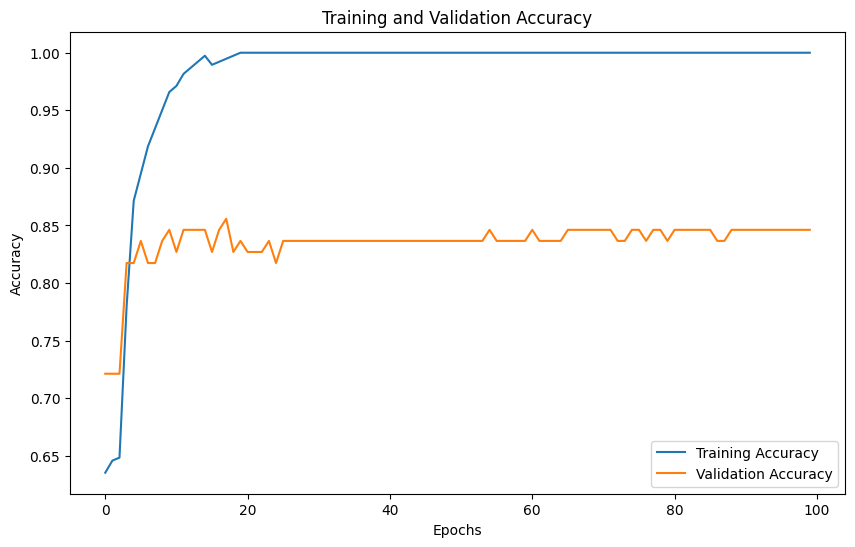

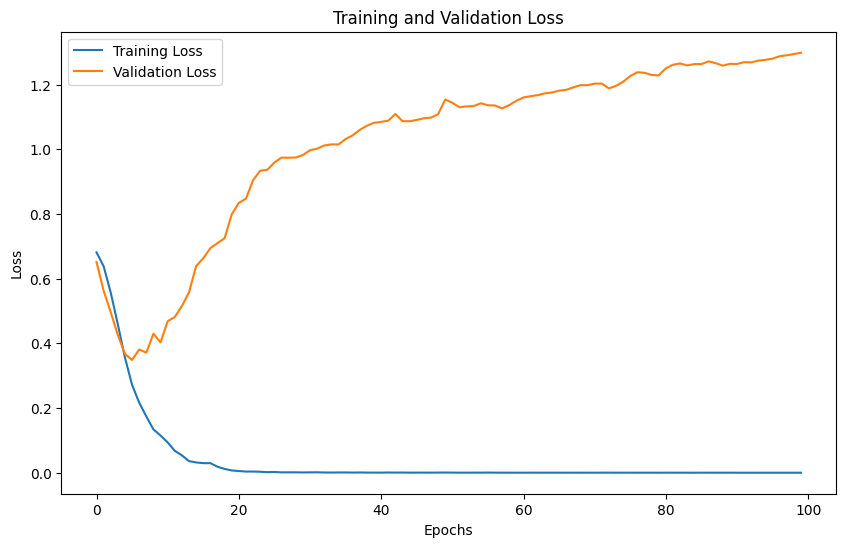

4/4 [==============================] - 0s 8ms/step


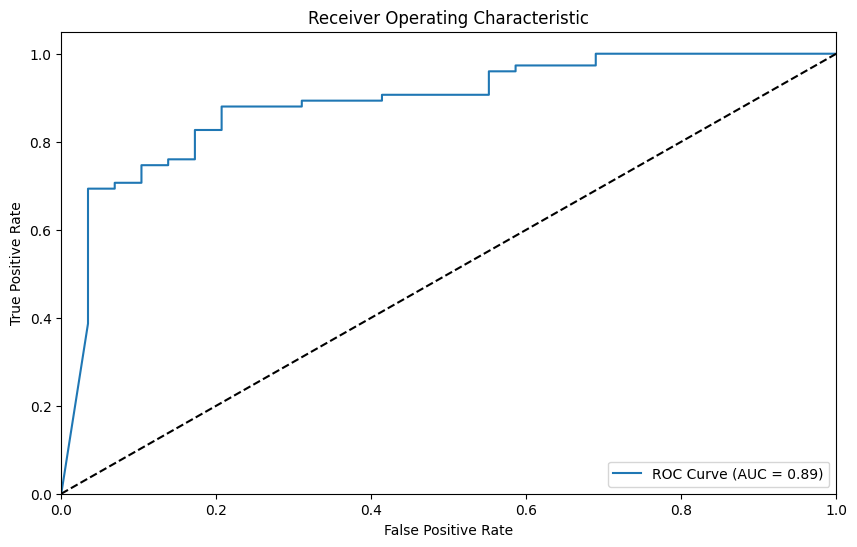

In [37]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

# Plot training loss and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Generate predictions
y_pred_prob = model.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label='ROC Curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

4/4 [==============================] - 0s 11ms/step


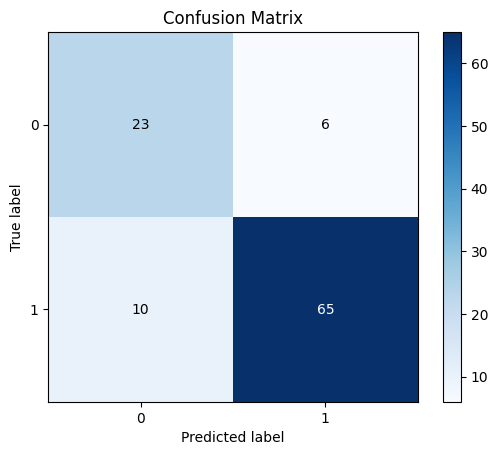

In [38]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

# Get the model's predictions on the test set
y_pred = model.predict(X_test)

# Convert the predictions to binary labels (0 or 1)
y_pred_labels = (y_pred > 0.5).astype(int).flatten()
skplt.metrics.plot_confusion_matrix(y_test, y_pred_labels, normalize=False, cmap='Blues')
plt.title('Confusion Matrix')
plt.show()